# 🎓 SVM+ORB Face Detector Training
## Classical Computer Vision Face Detection Model

Train your own face detector using:
- **ORB** (Oriented FAST + Rotated BRIEF) for feature extraction
- **Bag of Visual Words (BoVW)** with K-means clustering
- **Linear SVM** for classification

### 📦 What You'll Get:
1. `svm_model.pkl` - Trained SVM classifier
2. `bovw_encoder.pkl` - K-means codebook (BoVW encoder)
3. `scaler.pkl` - Feature scaler

### 📂 Dataset Structure Required:
```
dataset.zip
├── faces/          (positive samples - face images)
└── non_faces/      (negative samples - non-face images)
```

## 📥 Step 1: Setup & Upload Dataset

In [ ]:
# Install required packages
!pip install opencv-python scikit-learn scikit-image joblib numpy matplotlib seaborn tqdm -q

print("✓ Packages installed successfully")

✓ Packages installed successfully


In [ ]:
# Import libraries
import cv2
import numpy as np
import os
import pickle
import joblib
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported
OpenCV version: 4.11.0
NumPy version: 2.0.2


In [ ]:
# Upload your dataset.zip file
from google.colab import files

print("📤 Please upload your dataset.zip file (contains 'faces/' and 'non_faces/' folders)")
print("⏳ Waiting for upload...\n")

uploaded = files.upload()

print("\n✓ Upload complete!")

📤 Please upload your dataset.zip file (contains 'faces/' and 'non_faces/' folders)
⏳ Waiting for upload...



Saving DatasetsFaceDetection.zip to DatasetsFaceDetection.zip

✓ Upload complete!


In [ ]:
# Extract dataset
import zipfile

zip_filename = list(uploaded.keys())[0]
print(f"📦 Extracting {zip_filename}...")

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('data')

print("✓ Extraction complete")

# Verify structure
faces_dir = 'data/Datasets/faces'
non_faces_dir = 'data/Datasets/non_faces'

if os.path.exists(faces_dir):
    num_faces = len(os.listdir(faces_dir))
    print(f"✓ Found {num_faces} face images")
else:
    print("✗ 'faces/' folder not found!")

if os.path.exists(non_faces_dir):
    num_non_faces = len(os.listdir(non_faces_dir))
    print(f"✓ Found {num_non_faces} non-face images")
else:
    print("✗ 'non_faces/' folder not found!")

📦 Extracting DatasetsFaceDetection.zip...
✓ Extraction complete
✓ Found 2763 face images
✓ Found 2724 non-face images


## 🖼️ Step 2: Visualize Sample Images

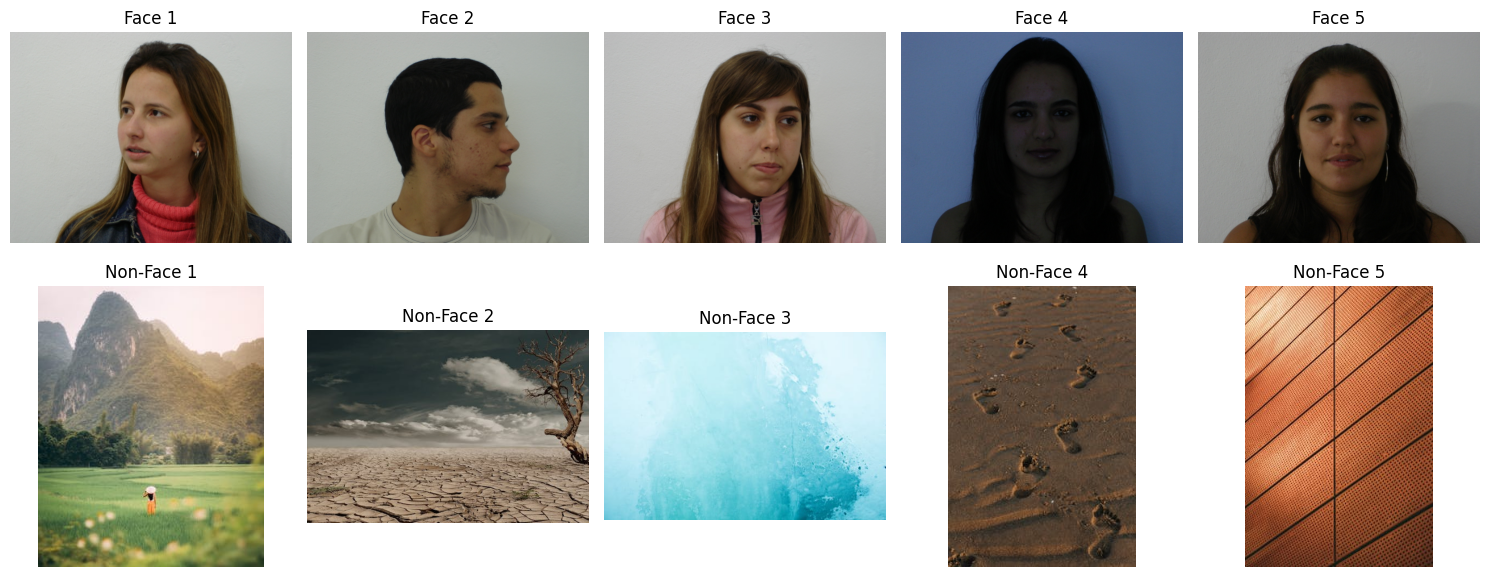

Dataset Summary:
  Faces: 2763
  Non-faces: 2724
  Total: 5487
  Balance: 50.4% faces


In [ ]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Show face samples
face_files = [f for f in os.listdir(faces_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
for i, fname in enumerate(face_files):
    img = cv2.imread(os.path.join(faces_dir, fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Face {i+1}')
    axes[0, i].axis('off')

# Show non-face samples
non_face_files = [f for f in os.listdir(non_faces_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
for i, fname in enumerate(non_face_files):
    img = cv2.imread(os.path.join(non_faces_dir, fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Non-Face {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f"Dataset Summary:")
print(f"  Faces: {num_faces}")
print(f"  Non-faces: {num_non_faces}")
print(f"  Total: {num_faces + num_non_faces}")
print(f"  Balance: {num_faces/(num_faces + num_non_faces)*100:.1f}% faces")

## ⚙️ Step 3: Configure Training Parameters

In [ ]:
# Training Configuration
CONFIG = {
    # ORB parameters
    'orb_max_keypoints': 500,
    'orb_scale_factor': 1.2,
    'orb_n_levels': 8,
    'orb_patch_size': 31,

    # Image preprocessing
    'target_size': (128, 128),  # Resize all images to this size

    # BoVW parameters
    'bovw_k': 256,  # Number of visual words (clusters)
    'bovw_max_descriptors': 200000,  # Max descriptors for k-means training

    # SVM parameters
    'svm_C': [0.1, 1.0, 10.0],  # Regularization parameter (will try all)
    'svm_max_iter': 10000,

    # Data split
    'train_ratio': 0.70,
    'val_ratio': 0.15,
    'test_ratio': 0.15,

    # Random seed for reproducibility
    'random_seed': 42
}

print("📋 Training Configuration:")
print("="*50)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*50)

📋 Training Configuration:
  orb_max_keypoints: 500
  orb_scale_factor: 1.2
  orb_n_levels: 8
  orb_patch_size: 31
  target_size: (128, 128)
  bovw_k: 256
  bovw_max_descriptors: 200000
  svm_C: [0.1, 1.0, 10.0]
  svm_max_iter: 10000
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15
  random_seed: 42


## 🔍 Step 4: Extract ORB Features

In [ ]:
# Initialize ORB detector
orb = cv2.ORB_create(
    nfeatures=CONFIG['orb_max_keypoints'],
    scaleFactor=CONFIG['orb_scale_factor'],
    nlevels=CONFIG['orb_n_levels'],
    edgeThreshold=CONFIG['orb_patch_size'],
    patchSize=CONFIG['orb_patch_size'],
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE
)

print(f"✓ ORB detector initialized")
print(f"  Max keypoints: {CONFIG['orb_max_keypoints']}")
print(f"  Scale factor: {CONFIG['orb_scale_factor']}")
print(f"  Pyramid levels: {CONFIG['orb_n_levels']}")

✓ ORB detector initialized
  Max keypoints: 500
  Scale factor: 1.2
  Pyramid levels: 8


In [ ]:
def load_and_preprocess_image(img_path, target_size):
    """Load image and preprocess for ORB feature extraction"""
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize
    gray = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)

    # Histogram equalization
    gray = cv2.equalizeHist(gray)

    return gray


def extract_orb_descriptors(img, orb_detector):
    """Extract ORB descriptors from image"""
    keypoints, descriptors = orb_detector.detectAndCompute(img, None)
    return descriptors


print("✓ Helper functions defined")

✓ Helper functions defined


In [ ]:
# Extract ORB descriptors from all images
print("🔍 Extracting ORB features from all images...\n")

all_descriptors = []  # For k-means training
descriptors_per_image = []  # Store descriptors for each image
labels = []  # Labels: 1=face, 0=non-face
filepaths = []  # Keep track of file paths

# Process face images (label = 1)
print("Processing face images...")
face_files = [f for f in os.listdir(faces_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for fname in tqdm(face_files, desc="Faces"):
    img_path = os.path.join(faces_dir, fname)
    img = load_and_preprocess_image(img_path, CONFIG['target_size'])

    if img is not None:
        descriptors = extract_orb_descriptors(img, orb)

        if descriptors is not None and len(descriptors) > 0:
            descriptors_per_image.append(descriptors)
            labels.append(1)  # Face
            filepaths.append(img_path)

            # Add to global descriptor pool
            all_descriptors.append(descriptors)

# Process non-face images (label = 0)
print("\nProcessing non-face images...")
non_face_files = [f for f in os.listdir(non_faces_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for fname in tqdm(non_face_files, desc="Non-faces"):
    img_path = os.path.join(non_faces_dir, fname)
    img = load_and_preprocess_image(img_path, CONFIG['target_size'])

    if img is not None:
        descriptors = extract_orb_descriptors(img, orb)

        if descriptors is not None and len(descriptors) > 0:
            descriptors_per_image.append(descriptors)
            labels.append(0)  # Non-face
            filepaths.append(img_path)

            # Add to global descriptor pool
            all_descriptors.append(descriptors)

print(f"\n✓ Feature extraction complete")
print(f"  Total images processed: {len(descriptors_per_image)}")
print(f"  Faces: {sum(labels)}")
print(f"  Non-faces: {len(labels) - sum(labels)}")

🔍 Extracting ORB features from all images...

Processing face images...


Faces:   0%|          | 0/2763 [00:00<?, ?it/s]


Processing non-face images...


Non-faces:   0%|          | 0/2724 [00:00<?, ?it/s]


✓ Feature extraction complete
  Total images processed: 5481
  Faces: 2763
  Non-faces: 2718


## 🎯 Step 5: Build BoVW Codebook (K-means)

In [ ]:
# Prepare descriptors for k-means
print("📊 Preparing descriptors for k-means clustering...\n")

# Stack all descriptors
all_descriptors_stacked = np.vstack(all_descriptors)
print(f"Total descriptors: {len(all_descriptors_stacked):,}")

# Sample descriptors if too many
max_desc = CONFIG['bovw_max_descriptors']
if len(all_descriptors_stacked) > max_desc:
    print(f"Sampling {max_desc:,} descriptors for k-means...")
    np.random.seed(CONFIG['random_seed'])
    indices = np.random.choice(len(all_descriptors_stacked), max_desc, replace=False)
    descriptors_for_kmeans = all_descriptors_stacked[indices]
else:
    descriptors_for_kmeans = all_descriptors_stacked

print(f"✓ Using {len(descriptors_for_kmeans):,} descriptors for k-means")
print(f"  Descriptor shape: {descriptors_for_kmeans.shape}")

📊 Preparing descriptors for k-means clustering...

Total descriptors: 684,105
Sampling 200,000 descriptors for k-means...
✓ Using 200,000 descriptors for k-means
  Descriptor shape: (200000, 32)


In [ ]:
# Train K-means clustering (BoVW codebook)
print(f"\n🎯 Training K-means with k={CONFIG['bovw_k']}...")
print("⏳ This may take a few minutes...\n")

kmeans = KMeans(
    n_clusters=CONFIG['bovw_k'],
    random_state=CONFIG['random_seed'],
    n_init=10,
    max_iter=300,
    verbose=1
)

kmeans.fit(descriptors_for_kmeans)

print(f"\n✓ K-means training complete")
print(f"  Number of clusters (visual words): {kmeans.n_clusters}")
print(f"  Inertia: {kmeans.inertia_:.2f}")
print(f"  Iterations: {kmeans.n_iter_}")


🎯 Training K-means with k=256...
⏳ This may take a few minutes...

Initialization complete
Iteration 0, inertia 25122730098.0.
Iteration 1, inertia 19777688331.793636.
Iteration 2, inertia 19399734300.322063.
Iteration 3, inertia 19233701525.308575.
Iteration 4, inertia 19138233075.1914.
Iteration 5, inertia 19075871641.585068.
Iteration 6, inertia 19031769411.65462.
Iteration 7, inertia 18998919499.169746.
Iteration 8, inertia 18972989760.816715.
Iteration 9, inertia 18951762442.0438.
Iteration 10, inertia 18934016694.81328.
Iteration 11, inertia 18919405570.060806.
Iteration 12, inertia 18907438446.9615.
Iteration 13, inertia 18897497642.032825.
Iteration 14, inertia 18888898388.10691.
Iteration 15, inertia 18881095326.72082.
Iteration 16, inertia 18874173701.056812.
Iteration 17, inertia 18867962226.4333.
Iteration 18, inertia 18862337562.52597.
Iteration 19, inertia 18857251574.428337.
Iteration 20, inertia 18852759428.54373.
Iteration 21, inertia 18848633850.04326.
Iteration 22, 

## 📊 Step 6: Encode Images to BoVW Histograms

In [ ]:
def encode_to_bovw(descriptors, kmeans_model, k, normalize='l2'):
    """Encode ORB descriptors to BoVW histogram"""
    if descriptors is None or len(descriptors) == 0:
        # Return uniform histogram for images with no keypoints
        return np.ones(k, dtype=np.float32) / k

    # Predict visual words
    visual_words = kmeans_model.predict(descriptors)

    # Build histogram
    histogram = np.bincount(visual_words, minlength=k).astype(np.float32)

    # Normalize
    if normalize == 'l1':
        norm = np.sum(histogram)
        if norm > 0:
            histogram = histogram / norm
    elif normalize == 'l2':
        norm = np.linalg.norm(histogram)
        if norm > 0:
            histogram = histogram / norm

    return histogram


print("✓ BoVW encoding function defined")

✓ BoVW encoding function defined


In [ ]:
# Encode all images to BoVW histograms
print("📊 Encoding images to BoVW histograms...\n")

X = []  # Features (BoVW histograms)
y = np.array(labels)  # Labels

for descriptors in tqdm(descriptors_per_image, desc="Encoding"):
    histogram = encode_to_bovw(descriptors, kmeans, CONFIG['bovw_k'], normalize='l2')
    X.append(histogram)

X = np.array(X)

print(f"\n✓ Encoding complete")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Features per image: {X.shape[1]}")

📊 Encoding images to BoVW histograms...



Encoding:   0%|          | 0/5481 [00:00<?, ?it/s]


✓ Encoding complete
  Feature matrix shape: (5481, 256)
  Labels shape: (5481,)
  Features per image: 256


## ✂️ Step 7: Split Dataset (70% / 15% / 15%)

In [ ]:
# Split dataset: 70% train, 15% val, 15% test
print("✂️ Splitting dataset...\n")

# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=CONFIG['random_seed'],
    stratify=y
)

# Second split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=CONFIG['random_seed'],
    stratify=y_temp
)

print(f"✓ Dataset split complete")
print(f"\nTraining set:")
print(f"  Total: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Faces: {sum(y_train)}")
print(f"  Non-faces: {len(y_train) - sum(y_train)}")

print(f"\nValidation set:")
print(f"  Total: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Faces: {sum(y_val)}")
print(f"  Non-faces: {len(y_val) - sum(y_val)}")

print(f"\nTest set:")
print(f"  Total: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Faces: {sum(y_test)}")
print(f"  Non-faces: {len(y_test) - sum(y_test)}")

✂️ Splitting dataset...

✓ Dataset split complete

Training set:
  Total: 3836 (70.0%)
  Faces: 1934
  Non-faces: 1902

Validation set:
  Total: 822 (15.0%)
  Faces: 414
  Non-faces: 408

Test set:
  Total: 823 (15.0%)
  Faces: 415
  Non-faces: 408


## 🔧 Step 8: Feature Scaling

In [ ]:
# Scale features using StandardScaler
print("🔧 Scaling features...\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Feature scaling complete")
print(f"  Scaler mean: {scaler.mean_[:5]}...")
print(f"  Scaler std: {scaler.scale_[:5]}...")

🔧 Scaling features...

✓ Feature scaling complete
  Scaler mean: [0.02338781 0.03288167 0.02138549 0.02894054 0.02335146]...
  Scaler std: [0.04399162 0.06434565 0.04251846 0.05340207 0.04754866]...


## 🤖 Step 9: Train Linear SVM

In [ ]:
# Hyperparameter tuning with GridSearchCV
print("🤖 Training Linear SVM with hyperparameter tuning...\n")

param_grid = {
    'C': CONFIG['svm_C']
}

svm = LinearSVC(
    max_iter=CONFIG['svm_max_iter'],
    random_state=CONFIG['random_seed'],
    dual=False  # Use primal formulation for faster training
)

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✓ Training complete")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Get best model
best_svm = grid_search.best_estimator_

🤖 Training Linear SVM with hyperparameter tuning...

Fitting 5 folds for each of 3 candidates, totalling 15 fits

✓ Training complete

Best parameters: {'C': 0.1}
Best cross-validation F1 score: 0.9482


## 📈 Step 10: Evaluate Model

In [ ]:
# Evaluate on validation set
print("📈 Evaluating on validation set...\n")

y_val_pred = best_svm.predict(X_val_scaled)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation Set Performance:")
print("="*50)
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1 Score:  {val_f1:.4f}")
print("="*50)

📈 Evaluating on validation set...

Validation Set Performance:
  Accuracy:  0.9611
  Precision: 0.9659
  Recall:    0.9565
  F1 Score:  0.9612


In [ ]:
# Evaluate on test set
print("\n📈 Evaluating on test set...\n")

y_test_pred = best_svm.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Test Set Performance:")
print("="*50)
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print("="*50)

print("\n" + classification_report(y_test, y_test_pred, target_names=['Non-Face', 'Face']))


📈 Evaluating on test set...

Test Set Performance:
  Accuracy:  0.9429
  Precision: 0.9279
  Recall:    0.9614
  F1 Score:  0.9444

              precision    recall  f1-score   support

    Non-Face       0.96      0.92      0.94       408
        Face       0.93      0.96      0.94       415

    accuracy                           0.94       823
   macro avg       0.94      0.94      0.94       823
weighted avg       0.94      0.94      0.94       823



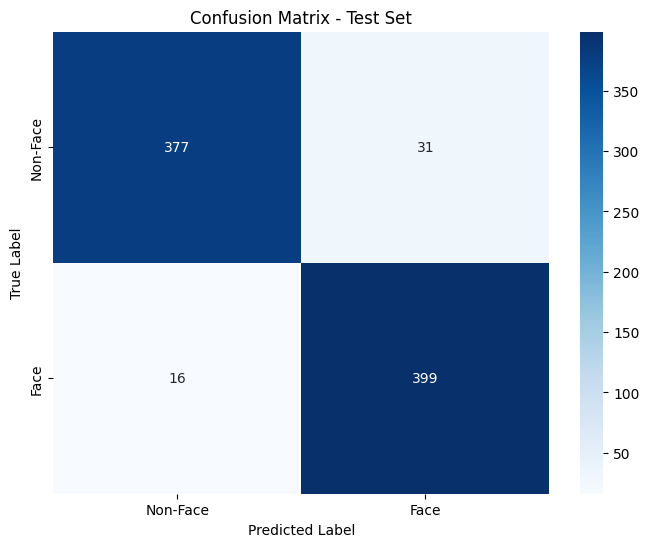


True Negatives:  377
False Positives: 31
False Negatives: 16
True Positives:  399


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Face', 'Face'], yticklabels=['Non-Face', 'Face'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

## 💾 Step 11: Save Models

In [ ]:
# Create output directory
output_dir = 'trained_models'
os.makedirs(output_dir, exist_ok=True)

print(f"💾 Saving models to '{output_dir}/'...\n")

# Save SVM model
svm_path = os.path.join(output_dir, 'svm_model.pkl')
joblib.dump(best_svm, svm_path)
print(f"✓ SVM model saved: {svm_path}")
print(f"  File size: {os.path.getsize(svm_path) / 1024:.1f} KB")

# Save BoVW encoder (k-means)
bovw_path = os.path.join(output_dir, 'bovw_encoder.pkl')
joblib.dump(kmeans, bovw_path)
print(f"✓ BoVW encoder saved: {bovw_path}")
print(f"  File size: {os.path.getsize(bovw_path) / 1024:.1f} KB")

# Save scaler
scaler_path = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")
print(f"  File size: {os.path.getsize(scaler_path) / 1024:.1f} KB")

# Save training config and metrics
config_path = os.path.join(output_dir, 'training_info.txt')
with open(config_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("SVM+ORB Face Detector Training Results\n")
    f.write("="*60 + "\n\n")

    f.write("Configuration:\n")
    f.write("-"*60 + "\n")
    for key, value in CONFIG.items():
        f.write(f"{key}: {value}\n")

    f.write("\n" + "="*60 + "\n")
    f.write("Dataset Split:\n")
    f.write("-"*60 + "\n")
    f.write(f"Training: {len(X_train)} samples\n")
    f.write(f"Validation: {len(X_val)} samples\n")
    f.write(f"Test: {len(X_test)} samples\n")

    f.write("\n" + "="*60 + "\n")
    f.write("Test Set Performance:\n")
    f.write("-"*60 + "\n")
    f.write(f"Accuracy:  {test_accuracy:.4f}\n")
    f.write(f"Precision: {test_precision:.4f}\n")
    f.write(f"Recall:    {test_recall:.4f}\n")
    f.write(f"F1 Score:  {test_f1:.4f}\n")
    f.write("="*60 + "\n")

print(f"✓ Training info saved: {config_path}")

print("\n" + "="*60)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)

💾 Saving models to 'trained_models/'...

✓ SVM model saved: trained_models/svm_model.pkl
  File size: 2.7 KB
✓ BoVW encoder saved: trained_models/bovw_encoder.pkl
  File size: 846.0 KB
✓ Scaler saved: trained_models/scaler.pkl
  File size: 6.6 KB
✓ Training info saved: trained_models/training_info.txt

✅ ALL MODELS SAVED SUCCESSFULLY!


## 📥 Step 12: Download Models

In [ ]:
# Zip all models for easy download
import shutil

print("📦 Creating models.zip for download...\n")

zip_filename = 'trained_models'
shutil.make_archive(zip_filename, 'zip', output_dir)

print(f"✓ Archive created: {zip_filename}.zip")
print(f"  Size: {os.path.getsize(zip_filename + '.zip') / 1024 / 1024:.2f} MB")

# Download
print("\n📥 Downloading models.zip...")
files.download(f'{zip_filename}.zip')

print("\n✅ Download complete!")
print("\n" + "="*60)
print("Next Steps:")
print("="*60)
print("1. Extract trained_models.zip")
print("2. Copy these files to your backend/models/ folder:")
print("   - svm_model.pkl")
print("   - bovw_encoder.pkl")
print("   - scaler.pkl")
print("3. Run: python face_detector_cli.py webcam --camera 0 --show")
print("="*60)

📦 Creating models.zip for download...

✓ Archive created: trained_models.zip
  Size: 0.36 MB

📥 Downloading models.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!

Next Steps:
1. Extract trained_models.zip
2. Copy these files to your backend/models/ folder:
   - svm_model.pkl
   - bovw_encoder.pkl
   - scaler.pkl
3. Run: python face_detector_cli.py webcam --camera 0 --show


## 📊 Summary Statistics

In [ ]:
# Print final summary
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print("\nModel Performance Summary:")
print("-"*60)
print(f"Dataset Size: {len(X)} images")
print(f"Training Set: {len(X_train)} (70%)")
print(f"Validation Set: {len(X_val)} (15%)")
print(f"Test Set: {len(X_test)} (15%)")
print("\nTest Set Metrics:")
print(f"  Accuracy:  {test_accuracy*100:.2f}%")
print(f"  Precision: {test_precision*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1 Score:  {test_f1*100:.2f}%")
print("\nModel Details:")
print(f"  ORB Keypoints: {CONFIG['orb_max_keypoints']}")
print(f"  BoVW Clusters (k): {CONFIG['bovw_k']}")
print(f"  SVM C parameter: {best_svm.C}")
print(f"  Feature dimension: {X.shape[1]}")
print("="*60)
print("\n✅ Models saved and ready for deployment!")
print("📥 Download the trained_models.zip file above")


🎉 TRAINING COMPLETE!

Model Performance Summary:
------------------------------------------------------------
Dataset Size: 5481 images
Training Set: 3836 (70%)
Validation Set: 822 (15%)
Test Set: 823 (15%)

Test Set Metrics:
  Accuracy:  94.29%
  Precision: 92.79%
  Recall:    96.14%
  F1 Score:  94.44%

Model Details:
  ORB Keypoints: 500
  BoVW Clusters (k): 256
  SVM C parameter: 0.1
  Feature dimension: 256

✅ Models saved and ready for deployment!
📥 Download the trained_models.zip file above
